In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'figures/'
os.environ['DATA590'] = '/mnt/kepler/sabarish/data/R590/'


#  Read DNS snapshots and tile them

In [22]:
fNameU = os.environ['DATA590'] + 'phys/u_it75000.dat'
# This is a bit messed up now. 
# The convention in DNS is that spanwise is y and wall-normal is z. 
# I don't want to use that convention. And hence the messiness below.
fNameW = os.environ['DATA590'] + 'phys/v_it75000.dat'
fNameV = os.environ['DATA590'] + 'phys/w_it75000.dat'
Nx = 384; Nz = 256; Ny = 384
with open(fNameU,'rb') as inFile:
    uArr = np.fromfile(inFile, dtype=np.float, count=-1)
uArr = uArr.reshape((Nx,Nz,Ny))

with open(fNameV,'rb') as inFile:
    vArr = np.fromfile(inFile, dtype=np.float, count=-1)
vArr = vArr.reshape((Nx,Nz,Ny))

with open(fNameW,'rb') as inFile:
    wArr = np.fromfile(inFile, dtype=np.float, count=-1)
wArr = wArr.reshape((Nx,Nz,Ny))

yCC = miscUtil.nodesCellCenters(nCells=384)


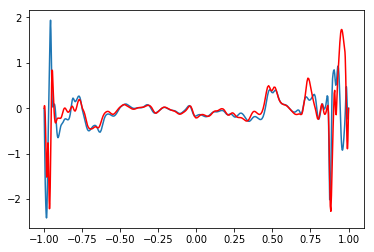

In [23]:
plt.plot(yCC,uArr[0,0]-uArr[0,-1])
plt.plot(yCC,uArr[0,-1]-uArr[0,-2],'r')
plt.show()

So, the data in the output binaries is periodic, going as [0,2pi) in x
and [0,pi) in z. The reason I plotted the figures above is to make sure that 2pi and pi in x and z are not included. 

Now, to get a flowfield that's useful on an $8\pi$x $3\pi$ domain, I just need to tile the flowfield.

In [24]:
uArr = np.tile(uArr, (4, 3, 1))
vArr = np.tile(vArr, (4, 3, 1))
wArr = np.tile(wArr, (4, 3, 1))
print(uArr.shape, vArr.shape, wArr.shape)

(1536, 768, 384) (1536, 768, 384) (1536, 768, 384)


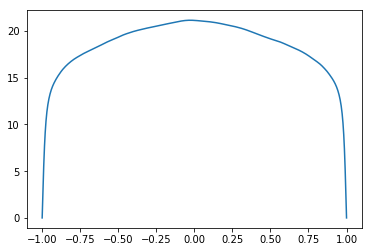

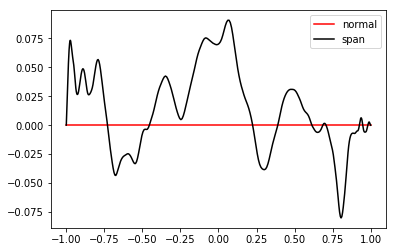

In [27]:
U = np.mean(np.mean(uArr, axis=1),axis=0)
V = np.mean(np.mean(vArr, axis=1),axis=0)
W = np.mean(np.mean(wArr, axis=1),axis=0)
plt.plot(yCC,U)
plt.show()
plt.plot(yCC,V,'r')
plt.plot(yCC,W,'k')
plt.legend(['normal','span'])
plt.show()

Looks okay, except that the V being exactly zero bothers me a bit. That's a bit too perfect.

Is that bad? What about W not being exactly zero? Well, at least I was hoping it would be smaller than what it is now. Maybe it's just this flowfield?

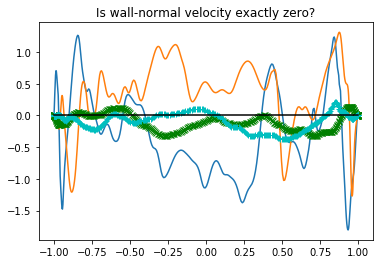

In [30]:
plt.plot(yCC, vArr[0,0])
plt.plot(yCC, vArr[0,192])
plt.plot(yCC, np.mean(vArr[:,10],axis=0),'gx')
plt.plot(yCC, np.mean(vArr[100],axis=0),'c+')
plt.plot(yCC, np.mean(np.mean(vArr,axis=1),axis=0),'k')
plt.title("Is wall-normal velocity exactly zero?")
plt.show()


Turns out, averaging the wall-normal velocity over the entire flowfield makes it exactly zero, even if it's not exactly zero at particular locations or when averaged along just streamwise or spanwise. It's always ''exactly'' zero at the wall anyway. 

Is that alright? The spanwise velocity isn't though. I suppose wall-normal is special. 


** Anyway, the averaged spanwise velocity is small enough to be considered zero. For now, I'll just go along with this.**

# Time to save the tiled flowfields

In [31]:
outPath = os.environ['DATA590'] + 'r590_1536x1024x384/'


outU = outPath + 'u_it1.dat'
# Again, messed up names coz of difference in convention
outV = outPath + 'w_it1.dat'
outW = outPath + 'v_it1.dat'

with open(outU,'wb') as outFile:
    uArr.tofile(outFile)
with open(outV,'wb') as outFile:
    vArr.tofile(outFile)
with open(outW,'wb') as outFile:
    wArr.tofile(outFile)

# Verify saved fields are okay

I'll repeat everything I've done for the earlier files and see if they're similar.

In [6]:
outPath = os.environ['DATA590'] + 'r590_1536x1024x384/'
fNameU = outPath + 'u_it1.dat'
fNameW = outPath + 'v_it1.dat'
fNameV = outPath + 'w_it1.dat'
Nx1 = 384*4; Nz1 = 256*3; Ny = 384
with open(fNameU,'rb') as inFile:
    uArr = np.fromfile(inFile, dtype=np.float, count=-1)
uArr = uArr.reshape((Nx1,Nz1,Ny))

with open(fNameV,'rb') as inFile:
    vArr = np.fromfile(inFile, dtype=np.float, count=-1)
vArr = vArr.reshape((Nx1,Nz1,Ny))

with open(fNameW,'rb') as inFile:
    wArr = np.fromfile(inFile, dtype=np.float, count=-1)
wArr = wArr.reshape((Nx1,Nz1,Ny))

yCC = miscUtil.nodesCellCenters(nCells=384)


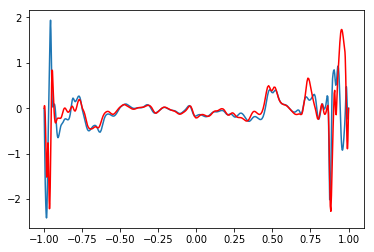

In [37]:
plt.plot(yCC,uArr[0,0]-uArr[0,-1])
plt.plot(yCC,uArr[0,-1]-uArr[0,-2],'r')
plt.show()

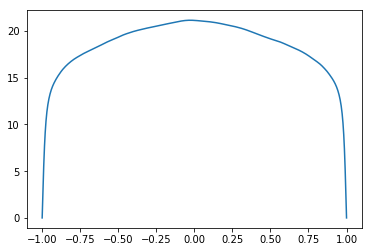

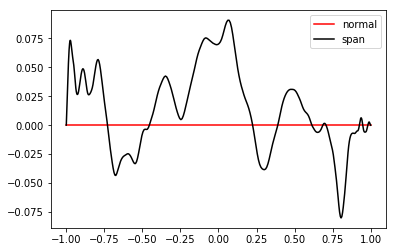

In [38]:
U = np.mean(np.mean(uArr, axis=1),axis=0)
V = np.mean(np.mean(vArr, axis=1),axis=0)
W = np.mean(np.mean(wArr, axis=1),axis=0)
plt.plot(yCC,U)
plt.show()
plt.plot(yCC,V,'r')
plt.plot(yCC,W,'k')
plt.legend(['normal','span'])
plt.show()

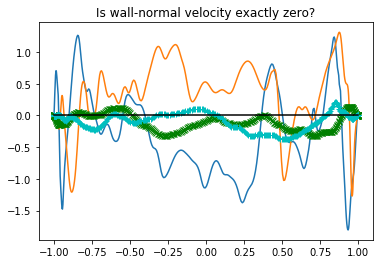

In [39]:
plt.plot(yCC, vArr[0,0])
plt.plot(yCC, vArr[0,192])
plt.plot(yCC, np.mean(vArr[:,10],axis=0),'gx')
plt.plot(yCC, np.mean(vArr[100],axis=0),'c+')
plt.plot(yCC, np.mean(np.mean(vArr,axis=1),axis=0),'k')
plt.title("Is wall-normal velocity exactly zero?")
plt.show()
